<a href="https://colab.research.google.com/github/alex-mat-s/NLP_ITMO/blob/master/ANLP_lab4_Alexandra_Matveeva_J41325c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [2]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 325 kB 5.5 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 48.0 MB/s 
     |████████████████████████████████| 134 kB 46.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.5 MB/s 
     |████████████████████████████████| 127 kB 48.0 MB/s 
     |████████████████████████████████| 144 kB 42.5 MB/s 
     |████████████████████████████████| 271 kB 22.1 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.8 MB/s 


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
data = dataset.data
data

{'test': MemoryMappedTable
 id: int32
 topic: int64
 question_title: string
 question_content: string
 best_answer: string
 ----
 id: [[0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999],[10000,10001,10002,10003,10004,10005,10006,10007,10008,10009,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999],[20000,20001,20002,20003,20004,20005,20006,20007,20008,20009,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999],[30000,30001,30002,30003,30004,30005,30006,30007,30008,30009,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999],[40000,40001,40002,40003,40004,40005,40006,40007,40008,40009,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999],[50000,50001,50002,50003,50004,50005,50006,50007,50008,50009,...,59990,59991,59992,59993,59994,59995,59996,59997,59998,59999]]
 topic: [[8,1,3,3,2,2,4,2,3,7,...,4,2,5,3,6,2,5,6,9,3],[8,4,8,6,6,6,6,8,9,7,...,5,0,0,4,3,0,7,4,8,3],[3,9,0,3,8,5,2,4,7,8,...,4,4,5,3,9,9,0,1,0,9],[1,4,4,9,4,

# Fine-tuning the model** (20 points)

In [6]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from datasets import load_metric, list_metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from IPython.display import display, HTML

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [7]:
# load tokenizer and model

In [8]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [9]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForMaskedLM.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

In [10]:
model

ElectraForMaskedLM(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=256, 

In [12]:
# look at the predictions of the model as-is before any fine-tuning

In [11]:
pipe = pipeline('fill-mask', model=model, tokenizer=tokenizer)

In [12]:
pipe("Why don't you ask [MASK]?")

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'm e'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'q u e s t i o n s'},
 {'score': 0.04395333677530289,
  'sequence': "why don't you ask them?",
  'token': 2068,
  'token_str': 't h e m'},
 {'score': 0.04017288610339165,
  'sequence': "why don't you ask why?",
  'token': 2339,
  'token_str': 'w h y'},
 {'score': 0.030024440959095955,
  'sequence': "why don't you ask yourself?",
  'token': 4426,
  'token_str': 'y o u r s e l f'}]

In [13]:
pipe("What is [MASK]")

[{'score': 0.9262322783470154,
  'sequence': 'what is?',
  'token': 1029,
  'token_str': '?'},
 {'score': 0.05156780779361725,
  'sequence': 'what is.',
  'token': 1012,
  'token_str': '.'},
 {'score': 0.021510401740670204,
  'sequence': 'what is!',
  'token': 999,
  'token_str': '!'},
 {'score': 0.0001196492012240924,
  'sequence': 'what is -',
  'token': 1011,
  'token_str': '-'},
 {'score': 0.00010928419214906171,
  'sequence': 'what is "',
  'token': 1000,
  'token_str': '"'}]

In [14]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'q u a n t u m'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 't h e o r e t i c a l'},
 {'score': 0.056394025683403015,
  'sequence': "let's talk about particle physics",
  'token': 10811,
  'token_str': 'p a r t i c l e'},
 {'score': 0.0332079641520977,
  'sequence': "let's talk about real physics",
  'token': 2613,
  'token_str': 'r e a l'},
 {'score': 0.022627945989370346,
  'sequence': "let's talk about mathematical physics",
  'token': 8045,
  'token_str': 'm a t h e m a t i c a l'}]

In [15]:
# dataset.set_format(type='torch')

train_dataset = dataset['train']
test_dataset = dataset['test']

In [16]:
len(train_dataset)

1400000

In [17]:
train_dataset = train_dataset.shuffle(seed=42).select(range(5000))
test_dataset = test_dataset.shuffle(seed=42).select(range(3500))

In [18]:
len(train_dataset)

5000

In [19]:
def display_random_examples(dataset=dataset, num_examples=5):
    assert num_examples < len(dataset)
    
    random_picks = []
    for i in range(num_examples):
        random_pick = random.randint(0,len(dataset)-1)
        random_picks.append(random_pick)
    
    df = pd.DataFrame(dataset[random_picks])
    display(HTML(df.to_html()))
        
display_random_examples(train_dataset, 3)

,id,topic,question_title,question_content,best_answer
0,1147630,3,"fafsa, loans and college? Which order should it be done?",The college I want to go to has to have $650 enclosed with the application. Should I submit a FAFSA first and get approved by them or does FAFSA require that I already be enrolled for the school. I also need to get a stafford loan so I need some advice on which order I need to do this. I know for sure that I need to be approved by FAFSA before I can get a Stafford loan but do I need to be accepted by the college before or after I do this?,"First submit your FAFSA- everyone is ""approved"" by fafsa- the amount you will receive in loans and scholarships is based upon your financial need- and that of your parents if you are not considered an Independent student. If you qualify as an independent study, (you would have to prove that you supported yourself for one year prior to being admitted into college) you would then qualify for the MOST in subsidized and unsubsidized stafford loans. Apply for FAFSA online, list the school/schools you are interested in. *you will need your income tax info for last year from you and your parents. And NO, you do NOT need to be accepted to a college first-it is better to submit the form before you commit to any college- you will then get EFC-expected family contribution $$$ so you can foresee what colleges you can truly afford to go to--- Good luck- again, google fafsa, there will be many other sites to help look for other scholarships."
1,237851,9,Rules of bike riding?,"If there are no signs prohibiting it, and no bike lane in the road, is it illegal to ride your bike on the sidewalk?\n\nAlso, when riding in the road, do you have to obey traffic laws as drivers do? What about if there is a bike lane?",Check this site about bike laws. They vary by state.
2,921187,4,how do you sign on aim with your away message on?,"i've seen people sign on aim with their away messages on, how di you do that? 10 points if it works!","k heres one way (it might not be the way that ur friends use tho) \n1. sign on AIM like you normally would\n2. put the ""hidden eye"" button on. (this means that other people see you as ""signed off"")\n3. put your away message on\n4. take off your ""hidden eye"". this will make it appear to others as though u just signed on for the first time (and your away message will still be on)"


In [20]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

In [21]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [22]:
tokenized_train_dataset.data

MemoryMappedTable
id: int32
topic: int64
question_title: string
question_content: string
best_answer: string
input_ids: list<item: int32>
  child 0, item: int32
token_type_ids: list<item: int8>
  child 0, item: int8
attention_mask: list<item: int8>
  child 0, item: int8
----
id: [[851713,251470,975899,194,918296,1109487,1097581,698707,773051,85215,...,623018,435965,846716,919380,482916,1049029,209315,242253,1134332,1152559],[105892,1384809,646020,306070,1289003,689272,471233,12101,450789,845935,...,244009,280216,247250,631753,1148483,663836,963607,1073399,325347,307614],[869629,1273918,1373967,1274837,101154,1209897,1092716,771953,525692,1117610,...,367046,780081,1214913,1217784,1240132,83552,516509,1335180,1096733,1188192],[1356336,687143,693033,859701,257954,544712,1100812,352133,960011,593925,...,428267,907185,1033286,280281,1275667,1259314,1306275,781894,521045,651102],[417073,755104,371204,335682,795804,1229334,189767,893381,1325835,943589,...,758085,970588,432747,1111814,441620,2

In [23]:
tokenized_test_dataset.data

MemoryMappedTable
id: int32
topic: int64
question_title: string
question_content: string
best_answer: string
input_ids: list<item: int32>
  child 0, item: int32
token_type_ids: list<item: int8>
  child 0, item: int8
attention_mask: list<item: int8>
  child 0, item: int8
----
id: [[3493,57546,8815,19332,15566,22963,21972,22093,1818,46044,...,1066,18844,17384,41212,9912,33477,17925,4710,13050,2493],[53263,38360,8249,20342,24121,2855,27762,54068,29004,24708,...,44552,58134,38904,47944,11993,34714,48384,34325,59238,45688],[56695,9762,34196,55410,27089,53354,16105,29162,33254,124,...,37945,44641,34697,26764,25013,3747,40338,56830,24347,57017],[41822,45167,10706,28163,28514,24048,58948,55952,17428,12321,...,57127,48119,29994,22783,11390,29846,33389,41678,46283,47209]]
topic: [[4,4,3,5,5,5,9,9,6,5,...,6,0,5,3,2,8,4,8,2,9],[4,9,2,1,9,6,2,7,1,1,...,7,0,5,9,6,5,1,5,1,2],[2,1,4,6,7,9,3,4,3,3,...,2,9,0,7,5,1,6,6,0,5],[7,5,0,4,2,7,6,8,7,2,...,0,0,9,0,6,7,2,5,4,7]]
question_title: [["Is the register

In [24]:
tokenized_test_dataset.set_format(type='torch')
tokenized_train_dataset.set_format(type='torch')

In [25]:
col_names = ['id', 'question_title', 'question_content', 'best_answer']

tokenized_test_dataset = tokenized_test_dataset.remove_columns(col_names)
tokenized_train_dataset = tokenized_train_dataset.remove_columns(col_names)

In [26]:
tokenized_test_dataset = tokenized_test_dataset.rename_column('topic', 'labels')

In [27]:
tokenized_train_dataset = tokenized_train_dataset.rename_column('topic', 'labels')

In [28]:
'''
    hyperparameters:
        - learning_rate
        - train_epoch
        - batch_size
'''

LEARNING_RATE = 5e-5
TRAIN_EPOCH = 5
BATCH_SIZE = 16

In [29]:
batched_train = DataLoader(tokenized_train_dataset, batch_size = BATCH_SIZE)
batched_test = DataLoader(tokenized_test_dataset, batch_size = BATCH_SIZE)

In [30]:
classification_model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [31]:
# define optimizer, sсheduler 
optimizer = torch.optim.AdamW(classification_model.parameters(), lr=LEARNING_RATE)

# scheduler
num_training_steps = TRAIN_EPOCH * len(batched_train)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [32]:
# fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score

In [33]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
classification_model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [34]:
classification_model.train()

epoch_losses = []

for epoch in range(TRAIN_EPOCH):
    losses = []

    for batch in tqdm(batched_train):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = classification_model(**batch)
        loss = outputs.loss
        losses.append(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    epoch_losses.append(torch.mean(torch.tensor(losses)))
    print(f"Epoch {epoch}\n Current loss {torch.mean(torch.tensor(losses))}\n")

100%|██████████| 313/313 [03:29<00:00,  1.50it/s]


Epoch 0
 Current loss 1.8755598068237305



100%|██████████| 313/313 [03:29<00:00,  1.49it/s]


Epoch 1
 Current loss 1.332714319229126



100%|██████████| 313/313 [03:29<00:00,  1.49it/s]


Epoch 2
 Current loss 1.1414389610290527



100%|██████████| 313/313 [03:29<00:00,  1.49it/s]


Epoch 3
 Current loss 1.0065592527389526



100%|██████████| 313/313 [03:29<00:00,  1.49it/s]

Epoch 4
 Current loss 0.9121224284172058



Text(0, 0.5, 'Loss')

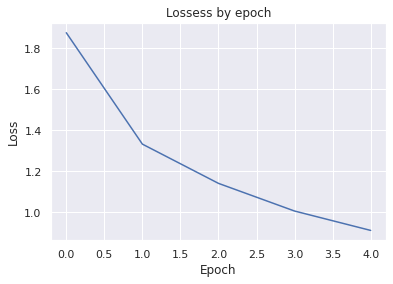

In [35]:
sns.set()

plt.plot(epoch_losses)
plt.title('Losses by epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [36]:
list_metrics()

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'gleu',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'pearsonr',
 'perplexity',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s']

In [38]:
metric = load_metric('f1')
classification_model.eval()

for batch in tqdm(batched_train):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = classification_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

f1_metric = metric.compute(average='weighted')
print(f'f1: {f1_metric}')

100%|██████████| 313/313 [01:16<00:00,  4.08it/s]

f1: {'f1': 0.7653889727807}



100%|██████████| 313/313 [01:16<00:00,  4.09it/s]

f1: {'f1': 0.7653889727807}


In [ ]:
# get the masked word prediction (sample sentences above) on the fine-tuned model

In [47]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
PATH = '/content/drive/MyDrive/ITMO/NLP'
classification_model.save_pretrained(PATH)

In [50]:
mask_model = ElectraForMaskedLM.from_pretrained(PATH)

Some weights of the model checkpoint at /content/drive/MyDrive/ITMO/NLP were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/MyDrive/ITMO/NLP and are newly initialized: ['generator_lm_head.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_prediction

In [51]:
pipe = pipeline('fill-mask', model=mask_model, tokenizer=tokenizer)

In [52]:
pipe("Why don't you ask [MASK]?")

[{'score': 0.00030580125167034566,
  'sequence': "why don't you ask tongue?",
  'token': 4416,
  'token_str': 't o n g u e'},
 {'score': 0.00028351644868962467,
  'sequence': "why don't you ask shortage?",
  'token': 15843,
  'token_str': 's h o r t a g e'},
 {'score': 0.0002735873276833445,
  'sequence': "why don't you ask throat?",
  'token': 3759,
  'token_str': 't h r o a t'},
 {'score': 0.00026126138982363045,
  'sequence': "why don't you ask favorites?",
  'token': 20672,
  'token_str': 'f a v o r i t e s'},
 {'score': 0.00025820863083936274,
  'sequence': "why don't you ask virginity?",
  'token': 26970,
  'token_str': 'v i r g i n i t y'}]

In [53]:
pipe("What is [MASK]")

[{'score': 0.00032070185989141464,
  'sequence': 'what is almost',
  'token': 2471,
  'token_str': 'a l m o s t'},
 {'score': 0.000310450152028352,
  'sequence': 'what is lungs',
  'token': 8948,
  'token_str': 'l u n g s'},
 {'score': 0.00026625109603628516,
  'sequence': 'what is doses',
  'token': 21656,
  'token_str': 'd o s e s'},
 {'score': 0.00026193581288680434,
  'sequence': 'what is nicaragua',
  'token': 15448,
  'token_str': 'n i c a r a g u a'},
 {'score': 0.00026148525648750365,
  'sequence': 'what is specializes',
  'token': 16997,
  'token_str': 's p e c i a l i z e s'}]

In [54]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.0004402179620228708,
  'sequence': "let's talk aboutnight physics",
  'token': 15864,
  'token_str': '# # n i g h t'},
 {'score': 0.00033267177059315145,
  'sequence': "let's talk aboutries physics",
  'token': 5134,
  'token_str': '# # r i e s'},
 {'score': 0.0003303617413621396,
  'sequence': "let's talk abouttle physics",
  'token': 9286,
  'token_str': '# # t l e'},
 {'score': 0.00030383202829398215,
  'sequence': "let's talk about cost physics",
  'token': 3465,
  'token_str': 'c o s t'},
 {'score': 0.00030176175641827285,
  'sequence': "let's talk abouttime physics",
  'token': 7292,
  'token_str': '# # t i m e'}]

In [ ]:
'''
    
'''

In [ ]:
# tune the training hyperparameters 

In [88]:
classification_model2 = ElectraForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [94]:
# let's try freezing (do not update the pretrained model weights) all the layers exept the ones for classification

for param in classification_model2.electra.parameters():
      param.requires_grad = False

In [95]:
LEARNING_RATE = 5e-5
TRAIN_EPOCH = 5
BATCH_SIZE = 16

In [96]:
batched_train = DataLoader(tokenized_train_dataset, batch_size = BATCH_SIZE)
batched_test = DataLoader(tokenized_test_dataset, batch_size = BATCH_SIZE)

In [97]:
# define optimizer, sсheduler 
optimizer = torch.optim.AdamW(classification_model2.parameters(), lr=LEARNING_RATE)

# scheduler
num_training_steps = TRAIN_EPOCH * len(batched_train)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [98]:
classification_model2.to(device)

classification_model2.train()

epoch_losses = []

for epoch in range(TRAIN_EPOCH):
    losses = []

    for batch in tqdm(batched_train):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = classification_model2(**batch)
        loss = outputs.loss
        losses.append(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    epoch_losses.append(torch.mean(torch.tensor(losses)))
    print(f"Epoch {epoch}\n Current loss {torch.mean(torch.tensor(losses))}\n")


100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Epoch 0
 Current loss 2.2992746829986572



100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


Epoch 1
 Current loss 2.286168336868286



100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


Epoch 2
 Current loss 2.2762198448181152



100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


Epoch 3
 Current loss 2.265979528427124



100%|██████████| 313/313 [01:17<00:00,  4.03it/s]

Epoch 4
 Current loss 2.260387897491455



Text(0, 0.5, 'Loss')

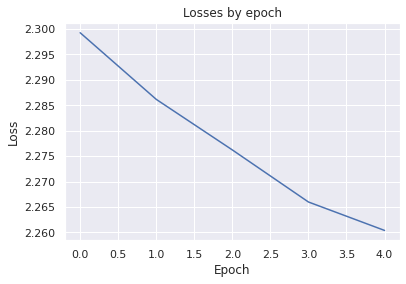

In [106]:
plt.plot(epoch_losses)
plt.title('Losses by epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [82]:
metric = load_metric('f1')
classification_model2.eval()

for batch in tqdm(batched_train):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = classification_model2(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

f1_metric = metric.compute(average='weighted')
print(f'f1: {f1_metric}')

100%|██████████| 157/157 [01:14<00:00,  2.12it/s]

f1: {'f1': 0.372881679669861}


In [100]:
classification_model2.save_pretrained(PATH)

In [101]:
mask_model2 = ElectraForMaskedLM.from_pretrained(PATH)

Some weights of the model checkpoint at /content/drive/MyDrive/ITMO/NLP were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/MyDrive/ITMO/NLP and are newly initialized: ['generator_lm_head.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias', 'generator_prediction

In [102]:
pipe = pipeline('fill-mask', model=mask_model2, tokenizer=tokenizer)

In [103]:

pipe("Why don't you ask [MASK]?")

[{'score': 0.0004913239390589297,
  'sequence': "why don't you ask blaine?",
  'token': 20002,
  'token_str': 'b l a i n e'},
 {'score': 0.0003274984483141452,
  'sequence': "why don't you askael?",
  'token': 21147,
  'token_str': '# # a e l'},
 {'score': 0.00030835249344818294,
  'sequence': "why don't you asklusion?",
  'token': 24117,
  'token_str': '# # l u s i o n'},
 {'score': 0.00030614694696851075,
  'sequence': "why don't you askgar?",
  'token': 6843,
  'token_str': '# # g a r'},
 {'score': 0.0002913288481067866,
  'sequence': "why don't you ask intention?",
  'token': 6808,
  'token_str': 'i n t e n t i o n'}]

In [104]:
pipe("What is [MASK]")

[{'score': 0.0004984412807971239,
  'sequence': 'what israil',
  'token': 15118,
  'token_str': '# # r a i l'},
 {'score': 0.00046170889982022345,
  'sequence': 'what isbry',
  'token': 25731,
  'token_str': '# # b r y'},
 {'score': 0.0004526679986156523,
  'sequence': 'what islusion',
  'token': 24117,
  'token_str': '# # l u s i o n'},
 {'score': 0.000421650183852762,
  'sequence': 'what isratic',
  'token': 23671,
  'token_str': '# # r a t i c'},
 {'score': 0.0003886965860147029,
  'sequence': 'what isedance',
  'token': 29605,
  'token_str': '# # e d a n c e'}]

In [105]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.00047877253382466733,
  'sequence': "let's talk about kaitlyn physics",
  'token': 28584,
  'token_str': 'k a i t l y n'},
 {'score': 0.00046052667312324047,
  'sequence': "let's talk aboutloh physics",
  'token': 24729,
  'token_str': '# # l o h'},
 {'score': 0.0004085285763721913,
  'sequence': "let's talk aboutrlin physics",
  'token': 19403,
  'token_str': '# # r l i n'},
 {'score': 0.00034685558057390153,
  'sequence': "let's talk abouthm physics",
  'token': 14227,
  'token_str': '# # h m'},
 {'score': 0.00031064695212990046,
  'sequence': "let's talk about romney physics",
  'token': 19615,
  'token_str': 'r o m n e y'}]